In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [10]:
def cx_sigm(n=10, t_max=200):
    # rand_btw_7-30 * {-1, 1}
    c1 = (torch.rand(n, 1) * 23 + 7) #* torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    t = torch.linspace(0, 1, t_max)
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (t-c2)))
    return data


t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)


noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y1 = cx_sigm(int(num_demos/2), t_steps).view(int(num_demos/2), t_steps, 1)
y1 += torch.unsqueeze(noise, 2)

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)

vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy1 = cx_sigm(int(num_val/2), t_steps).view(int(num_val/2), t_steps, 1)
vy1 += torch.unsqueeze(vnoise, 2)

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


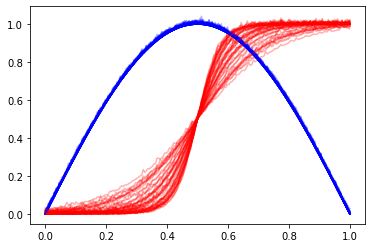

In [11]:
for i in range(int(num_demos/2)):
    plt.plot(x[i, :, 0], y[i, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+int(num_demos/2), :, 0], y[i+int(num_demos/2), :, 0], 'r', alpha=0.3)
plt.show()

In [12]:
n_max = 14

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda()
    else:
        return x, y

In [13]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )
        

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        return self.f0(z_target), self.f1(z_target)


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def plot_trajs(path, i, x, y, pt, col):    
    plt.plot(x, y, 'k', alpha=0.5)
    plt.plot(x, pt[:, 0], col, alpha=0.75)
    plt.savefig(path+str(i)+'.png')    
    plt.close()


def validate(plot=False, path='', it=-1):
    verr=torch.zeros(num_val)
    
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj0, pred_traj1 = torch.zeros_like(val_y), torch.zeros_like(val_y)
            pred_traj0[cond_step, :] = val_y[cond_step, :]
            pred_traj1[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                pred0, pred1 = model(observation, torch.unsqueeze(val_x[t], 0))
                pred_traj0[t, :], _ = pred0.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std
                pred_traj1[t, :], _ = pred1.chunk(2, dim = -1)
            
            verr0, verr1 = torch.sum((val_y - pred_traj0) ** 2), torch.sum((val_y - pred_traj1) ** 2)
#             print(f'v0: {verr0}\nv1: {verr1}')
            if verr0 < verr1:
                verr[i] = verr0
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj0.cpu(), 'r')
            else:
                verr[i] = verr1
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj1.cpu(), 'b')
            
    return torch.mean(verr)

In [ ]:
root_path = f'val/{int(time.time())}'

model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
plot_after_iter = 25000
iters = 10000000

losses = []
min_verr = 1e6
epsilon = 0.1

for i in range(iters):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, tx)
    loss0, loss1 = log_prob_loss(ty, ty_preds[0]), log_prob_loss(ty, ty_preds[1])
    
    if torch.rand(1) < epsilon:
        if torch.rand(1) < 0.5:
            model.f0.requires_grad = True
            model.f1.requires_grad = False
            loss0.backward()
        else:
            model.f0.requires_grad = False
            model.f1.requires_grad = True
            loss1.backward()
        epsilon = max(epsilon * 0.95, 1e-6)
    else:
        if loss0 < loss1:
            model.f0.requires_grad = True
            model.f1.requires_grad = False
            loss0.backward()
        else:
            model.f0.requires_grad = False
            model.f1.requires_grad = True
            loss1.backward()
    
    optimizer.step()
#     if i%500 == 0:
#         print(f'{i}: {loss}')
    
    if i%val_after_iter == 0:
        if i%plot_after_iter == 0:
            d_path = f'{root_path}/{str(i)}/'
            try:
                os.makedirs(d_path)
            except:
                pass
            verr = validate(True, d_path, i)
        else:
            verr = validate()
        print(f"{i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            print(f"Best validation")
            torch.save(model.state_dict(), f'{path}/best_model.pt')

0: 89.76448059082031
Best validation
2500: 42.07109069824219
Best validation
5000: 39.67683029174805
Best validation
7500: 40.83002471923828
10000: 46.853816986083984
12500: 37.99738311767578
Best validation
15000: 36.72172164916992
Best validation
17500: 35.697486877441406
Best validation
20000: 35.067195892333984
Best validation
22500: 31.403034210205078
Best validation
25000: 32.101871490478516
27500: 29.61319351196289
Best validation
30000: 27.03445053100586
Best validation
32500: 24.28578758239746
Best validation
35000: 23.05478858947754
Best validation
37500: 21.139631271362305
Best validation
40000: 20.294038772583008
Best validation
42500: 23.071956634521484
45000: 21.60226821899414
47500: 20.93560218811035
50000: 21.087032318115234
52500: 23.127592086791992
55000: 22.819965362548828
57500: 21.972047805786133
60000: 23.3027400970459
62500: 21.456205368041992
65000: 20.77227020263672
67500: 19.027278900146484
Best validation
70000: 22.6083984375
72500: 20.71205711364746
75000: 1

742500: 22.208810806274414
745000: 21.944416046142578
747500: 22.12135887145996
750000: 18.81513786315918
752500: 19.215091705322266
755000: 20.20290184020996
757500: 18.575054168701172
760000: 18.53657341003418
762500: 21.35329246520996
765000: 23.6068172454834
767500: 22.886125564575195
770000: 21.814197540283203
772500: 22.063772201538086
775000: 21.630687713623047
777500: 21.621906280517578
780000: 21.37448501586914
782500: 19.350231170654297
785000: 19.496082305908203
787500: 21.001293182373047
790000: 22.913387298583984
792500: 22.442691802978516
795000: 22.79863166809082
797500: 22.5043888092041
800000: 22.217397689819336
802500: 21.056365966796875
805000: 21.973188400268555
807500: 22.359649658203125
810000: 20.74878692626953
812500: 21.273361206054688
815000: 20.83605194091797
817500: 21.91123390197754
820000: 23.949037551879883
822500: 22.601879119873047
825000: 22.112855911254883
827500: 23.402345657348633
830000: 21.467458724975586
832500: 19.88348960876465
835000: 20.86983

1495000: 19.127248764038086
1497500: 18.831378936767578
1500000: 21.613948822021484
1502500: 22.094348907470703
1505000: 20.831153869628906
1507500: 21.00179672241211
1510000: 21.152767181396484
1512500: 22.391010284423828
1515000: 21.734888076782227
1517500: 20.491424560546875
1520000: 20.230318069458008
1522500: 21.653268814086914
1525000: 21.797224044799805
1527500: 20.69837188720703
1530000: 22.32638931274414
1532500: 19.784393310546875
1535000: 18.788015365600586
1537500: 19.06009864807129
1540000: 19.831310272216797
1542500: 20.308778762817383
1545000: 16.925739288330078
1547500: 18.55252456665039
1550000: 16.34235954284668
1552500: 17.15762710571289
1555000: 17.317218780517578
1557500: 21.961013793945312
1560000: 19.77224349975586
1562500: 21.817739486694336
1565000: 21.348407745361328
1567500: 20.80229949951172
1570000: 19.254335403442383
1572500: 18.93535041809082
1575000: 17.379268646240234
1577500: 19.798160552978516
1580000: 18.722623825073242
1582500: 19.254314422607422
15

2240000: 20.65726661682129
2242500: 19.849727630615234
2245000: 20.709606170654297
2247500: 20.726266860961914
2250000: 22.00089454650879
2252500: 21.187023162841797
2255000: 20.74965476989746
2257500: 20.761985778808594
2260000: 21.469026565551758
2262500: 20.73496437072754
2265000: 20.283893585205078
2267500: 20.896690368652344
2270000: 20.819580078125
2272500: 18.91165542602539
2275000: 19.378036499023438
2277500: 20.61223793029785
2280000: 19.86924171447754
2282500: 19.31204605102539
2285000: 19.111900329589844
2287500: 19.795883178710938
2290000: 19.22667121887207
2292500: 21.3092041015625
2295000: 21.352575302124023
2297500: 21.9482479095459
2300000: 21.176891326904297
2302500: 21.297582626342773
2305000: 21.683517456054688
2307500: 21.150136947631836
2310000: 21.15825843811035
2312500: 21.35125732421875
2315000: 21.572811126708984
2317500: 21.789417266845703
2320000: 21.45924186706543
2322500: 21.83402442932129
2325000: 21.285329818725586
2327500: 21.811386108398438
2330000: 21.

2982500: 21.9611873626709
2985000: 22.165695190429688
2987500: 21.765480041503906
2990000: 22.32950782775879
2992500: 21.828510284423828
2995000: 21.700084686279297
2997500: 21.862327575683594
3000000: 22.155845642089844
3002500: 21.817127227783203
3005000: 22.65720558166504
3007500: 22.61286163330078
3010000: 22.120485305786133
3012500: 21.42914390563965
3015000: 21.010366439819336
3017500: 21.483699798583984
3020000: 21.67013168334961
3022500: 21.86224365234375
3025000: 21.749576568603516
3027500: 21.09778594970703
3030000: 22.42698097229004
3032500: 21.283632278442383
3035000: 22.74209213256836
3037500: 22.897342681884766
3040000: 22.411205291748047
3042500: 22.67165184020996
3045000: 22.36469078063965
3047500: 21.56532096862793
3050000: 20.757038116455078
3052500: 20.690462112426758
3055000: 20.971752166748047
3057500: 19.869571685791016
3060000: 20.973703384399414
3062500: 19.804658889770508
3065000: 22.673307418823242
3067500: 23.149600982666016
3070000: 21.234390258789062
307250

3725000: 21.043081283569336
3727500: 21.316980361938477
3730000: 20.765254974365234
3732500: 20.548240661621094
3735000: 22.253198623657227
3737500: 21.69418716430664
3740000: 21.94588851928711
3742500: 21.324954986572266
3745000: 22.239215850830078
3747500: 22.34328842163086
3750000: 20.034868240356445
3752500: 22.153493881225586
3755000: 21.9644718170166
3757500: 22.48746109008789
3760000: 22.024646759033203
3762500: 21.987234115600586
3765000: 22.762197494506836
3767500: 22.49905014038086
3770000: 22.900466918945312
3772500: 22.841571807861328
3775000: 22.95309066772461
3777500: 22.33477210998535
3780000: 21.786895751953125
3782500: 21.36343002319336
3785000: 22.568626403808594
3787500: 22.200082778930664
3790000: 22.206470489501953
3792500: 22.161405563354492
3795000: 21.658794403076172
3797500: 21.938037872314453
3800000: 21.68663215637207
3802500: 21.320480346679688
3805000: 21.793149948120117
3807500: 22.04814338684082
3810000: 21.278518676757812
3812500: 22.271135330200195
3815